In [1]:
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from scipy.ndimage.measurements import label

%matplotlib inline
print('Done')

Done


In [2]:
def conv_color(img, color_space='RGB', read_lib='MPL'):
    """
    Converts an image to a chosen color space.

    :param img: A given image.
    :param color_space: Chosen color space (RGB/HSV/LUV/HLS/YUV/YCrCb).
    :param read_lib: Library used for reading the image (matplotlib "MPL"/opencv "CV").

    :return: cvt_img: The converted image.
    """
    if read_lib == 'MPL':  # MatPlotLib (RGB)
        if color_space != 'RGB':
            if color_space == 'HSV':
                cvt_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                cvt_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                cvt_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                cvt_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                cvt_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else:
            cvt_img = np.copy(img)

    else:  # OpenCV (BGR)
        if color_space != 'RGB':
            if color_space == 'HSV':
                cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        else:
            cvt_img = np.copy(img)

    return cvt_img

print('Done')

Done


In [3]:
# Define a function to return HOG features and visualization:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm='L2-Hys',
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image

    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm='L2-Hys',
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    spat_features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return spat_features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately:
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)

    # Concatenate the histograms into a single feature vector:
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    # Return the feature vector:
    return hist_features

print('Done')

Done


In [4]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []

    #2) Apply color conversion if other than 'RGB'
    feature_image = conv_color(img, color_space)

    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)

    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)

    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

print('Done')

Done


In [5]:
# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size:
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched:
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y:
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

    # Compute the number of windows in x/y:
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)

    # Initialize a list to append window positions to:
    window_list = []

    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))

    # Return the list of windows:
    return window_list

# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

print('Done')

Done


In [6]:
# # Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler,
              color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list that will contain bounding boxes of found cars:
    bboxes = []

    # test_features = []
    #
    # draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = conv_color(img_tosearch, color_space=color_space, read_lib='CV')

    # Rescale image if not 1.0 scale:
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    if hog_feat == True:
        if hog_channel == 'ALL':
            ch1 = ctrans_tosearch[:, :, 0]
            ch2 = ctrans_tosearch[:, :, 1]
            ch3 = ctrans_tosearch[:, :, 2]
        else:
            ch1 = ctrans_tosearch[:, :, hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image:
    if hog_feat == True:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        if hog_channel == 'ALL':
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            if spatial_feat == True:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                # test_features.append(spatial_features)

            if hist_feat == True:
                hist_features = color_hist(subimg, nbins=hist_bins)
                # test_features.append(hist_features)

            # Extract HOG for this patch
            if hog_feat == True:
                hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                if hog_channel == 'ALL':
                    hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:
                    hog_features = hog_feat1
                # test_features.append(hog_features)

            # Scale features:
            if spatial_feat == True:
                if hist_feat == True:
                    if hog_feat == True:
                        test_features = X_scaler.transform(
                            np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                    else:
                        test_features = X_scaler.transform(
                            np.hstack((spatial_features, hist_features)).reshape(1, -1))
                elif hog_feat == True:
                    test_features = X_scaler.transform(
                        np.hstack((spatial_features, hog_features)).reshape(1, -1))
                else:
                    test_features = X_scaler.transform(
                        np.hstack(spatial_features).reshape(1, -1))
            elif hist_feat == True:
                if hog_feat == True:
                    test_features = X_scaler.transform(
                        np.hstack((hist_features, hog_features)).reshape(1, -1))
                else:
                    test_features = X_scaler.transform(
                        np.hstack(hist_features).reshape(1, -1))
            else:
                test_features = X_scaler.transform(
                    np.hstack(hog_features).reshape(1, -1))

            # Make a prediction:
            test_prediction = svc.predict(test_features.reshape(1, -1))

            #
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)

                top_left = (xbox_left, ytop_draw + ystart)
                bottom_right = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
                bboxes.append((top_left, bottom_right))
                # cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                #               (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)

    return bboxes

print('Done')

Done


In [7]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=4):
    # Make a copy of the image:
    imcopy = np.copy(img)

    # Iterate through the bounding boxes:
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    # Return the image copy with boxes drawn:
    return imcopy

print('Done')

Done


In [8]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

print('Done')

Done


In [9]:
test_imgs_path = 'test_images/'
# test_imgs_path = 'video_frames/'
test_img_filename = 'test1.jpg'
# test_img_filename = 'frame0.jpg'
# test_img_filename = 'bbox-example-image.jpg'
# test_img = cv2.imread(test_imgs_path + test_img_filename)
# test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = mpimg.imread(test_imgs_path + test_img_filename)

print('Done')

Done


In [10]:
# Loading the model classifier and parameters:
model_filename = 'model_big_mpl_v1.p'
if os.path.exists(model_filename):
    print('Model file found')
    with open(model_filename, mode='rb') as f:
        model = pickle.load(f)
    svc = model['svc']
    X_scaler = model['scaler']
    color_space = model['color_space']
    spatial_size = model['spatial_size']
    hist_bins = model['hist_bins']
    orient = model['orient']
    pix_per_cell = model['pix_per_cell']
    cell_per_block = model['cell_per_block']
    hog_channel = model['hog_channel']
    spatial_feat = model['spatial_feat']
    hist_feat = model['hist_feat']
    hog_feat = model['hog_feat']
    
print('Done')

Model file found
Done


In [29]:
bboxes_list = []
bbox_list = []
print('Done')

Done


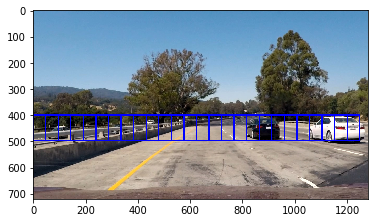

In [30]:
ystart = 400
ystop = 500
y_start_stop = [ystart, ystop]
xy_window = (96, 96)
xy_overlap = (0.5, 0.5)

windows = slide_window(test_img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                    xy_window=xy_window, xy_overlap=xy_overlap)

hot_windows = search_windows(test_img, windows, svc, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
bboxes_list.append(hot_windows)

window_img = draw_boxes(test_img, hot_windows, color=(0, 0, 255))
plt.imshow(window_img)

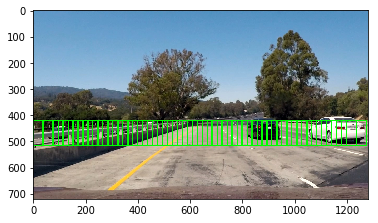

In [31]:
ystart = 420
ystop = 520
y_start_stop = [ystart, ystop]
xy_window = (96, 96)
xy_overlap = (0.6, 0.6)

windows = slide_window(test_img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                    xy_window=xy_window, xy_overlap=xy_overlap)

hot_windows = search_windows(test_img, windows, svc, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
bboxes_list.append(hot_windows)

window_img = draw_boxes(test_img, hot_windows, color=(0, 255, 0))
plt.imshow(window_img)

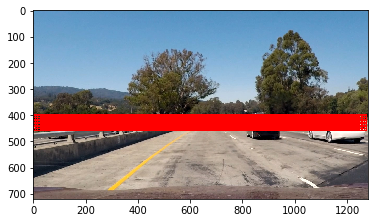

In [32]:
ystart = 400
ystop = 460
y_start_stop = [ystart, ystop]
xy_window = (32, 32)
xy_overlap = (0.7, 0.7)

windows = slide_window(test_img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                    xy_window=xy_window, xy_overlap=xy_overlap)

hot_windows = search_windows(test_img, windows, svc, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
bboxes_list.append(hot_windows)

window_img = draw_boxes(test_img, hot_windows, color=(255, 0, 0))
plt.imshow(window_img)

In [34]:
ystart = 400
ystop = 660
scale = 1.0
bboxes_list.append(find_cars(test_img, ystart=ystart, ystop=ystop, scale=scale, svc=svc, X_scaler=X_scaler,
                        color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))

for bboxes in bboxes_list:
    for bbox in bboxes:
        bbox_list.append(bbox)
print(len(bbox_list))


1252


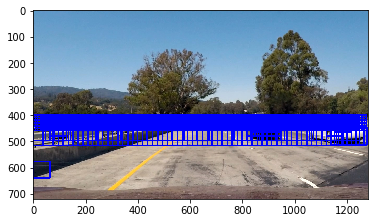

In [35]:
window_img = draw_boxes(test_img, bbox_list)

plt.imshow(window_img)

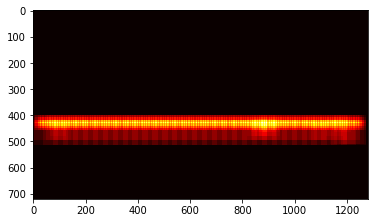

In [36]:
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, bbox_list)

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying
heatmap = np.clip(heat, 0, 255)

plt.imshow(heatmap, cmap='hot')

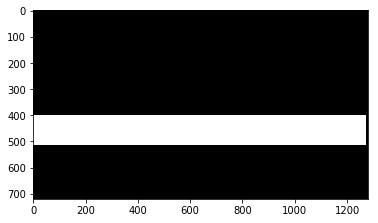

In [37]:
# Find final boxes from heatmap using label function
labels = label(heatmap)

plt.imshow(labels[0], cmap='gray')

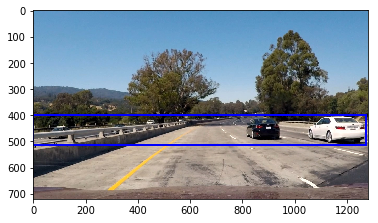

In [38]:
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

plt.imshow(draw_img)